In [1]:
!pip install nonconformist

In [2]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from nonconformist.base import ClassifierAdapter
from nonconformist.icp import IcpClassifier
from nonconformist.nc import ClassifierNc, MarginErrFunc
import matplotlib.pyplot as plt

In [3]:
df = pd.read_excel('Baidu_SMART Dataset.xlsx')

features_col = ['Raw Read Error Rate','SpinUpTime','Reallocated Sector Count','Seek Error Rate', \
                'Power on Hours','Reported Uncorrectable Error', 'High Fly Writes', \
                'Temperature Celsius', 'Hardware ECC Recovered', 'Current Pending Sector', 'Reallocated Sectors Count', \
                'Current Pending Sectors counts']

X = df[features_col].to_numpy()
y = df['Drive Status'].to_numpy()

In [4]:
idx = np.random.permutation(X.shape[0])
train = idx[:int(idx.size / 3)]
calibrate = idx[int(idx.size / 3):int(2 * idx.size / 3)]
test = idx[int(2 * idx.size / 3):]

In [5]:
icp = IcpClassifier(ClassifierNc(ClassifierAdapter(RandomForestClassifier()),
                                 MarginErrFunc()))
icp.fit(X[train, :], y[train])
icp.calibrate(X[calibrate, :], y[calibrate])

In [6]:
prediction = icp.predict(X[test, :], significance=0.1)
header = np.array(['c0','c1','Truth'])
header

array(['c0', 'c1', 'Truth'], dtype='<U5')

Text(0, 0.5, 'Credibility')

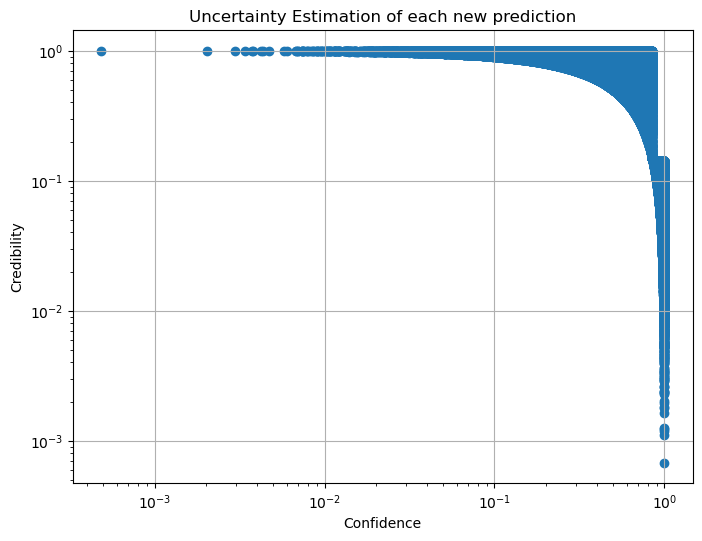

In [7]:
n_instances = y.size
idx = np.random.permutation(n_instances)

nc = ClassifierNc(ClassifierAdapter(RandomForestClassifier(n_estimators=100)))
icp = IcpClassifier(nc)

icp.fit(X[train, :], y[train])
icp.calibrate(X[calibrate, :], y[calibrate])

res = pd.DataFrame(icp.predict_conf(X[test, :]),
				   columns=['Label', 'Confidence', 'Credibility'])
cf = res.iloc[:,1]
c = res.iloc[:,2]

res = {'Credibility':c , 'Confidence':cf}        
plt.figure(num=None, figsize=(8, 6), dpi=100, facecolor='w', edgecolor='k')
plt.scatter(cf,c)
plt.yscale('log')
plt.xscale('log')
plt.grid(True)
plt.title('Uncertainty Estimation of each new prediction')
plt.xlabel('Confidence')
plt.ylabel('Credibility')
